<a href="https://colab.research.google.com/github/AhmedThahir/Certificate_Generator_Google_Dev_Club/blob/main/Certificates_Generation_Mail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GDSC Certificates Generation + Mail

***Read the instructions before proceeding.*** There have been changes in this script and the backend.

---

## Steps

1. Login with GDSC Mail
2. Run All Cells
3. Allow GDrive mounting authentication (if asked)
4. Verify the example output
5. Enter password to confirm

---

Made with Python and <3 by Ahmed Thahir

# Querying Data

In [168]:
import pandas as pd

In [169]:
def gsheet(spreadsheet_id, sheet_id=None, sheet_name=None):
  if sheet_id:
    return f"https://docs.google.com/spreadsheets/d/{spreadsheet_id}/gviz/tq?tqx=out:csv&gid={sheet_id}"
  elif sheet_name:
    return f"https://docs.google.com/spreadsheets/d/{spreadsheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
  else:
    return None

In [170]:
df = pd.read_csv(gsheet("1BnzmkWo0EH8subvl_g7FQZ_6Nc8MaiA81gQ25HEfHM0", sheet_id=2041472620))
df = df.drop_duplicates()
# df = pd.read_csv(gsheet("1BnzmkWo0EH8subvl_g7FQZ_6Nc8MaiA81gQ25HEfHM0", sheet_name = "Send_Certificate"))

List = df.count()
flag = all(element == List[0] for element in List)

if flag != 1:
  print("Missing values!")
  exit()

In [171]:
from datetime import datetime

def pretty_date(date):
  return datetime.strptime(date, '%Y-%m-%d').strftime('%b %d, %Y')

# Generate Certificates

In [172]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [173]:
folder = "/content/drive/MyDrive/GDSC/Admin/GDSC_Certificates"

fonts_folder = f"{folder}/fonts"

import os
output_folder = f'{folder}/output'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [174]:
from PIL import Image, ImageDraw, ImageFont

img = Image.open(f'{folder}/template.png')
W, H = img.size

In [175]:
def draw_certificate(person, y_offset=0):
    im = img.copy()

    title = "CERTIFICATE OF "
    description = "has "
    if person["Type"] == 'Workshop':
        # Workshop
        title += "COMPLETION"
        description += "successfully completed the workshop -"
    elif person["Type"] == 'Competition':
        # Competition
        title += "PARTICIPATION"
        description += "participated in the"
    
    description += f" {person['Event']}\nheld on {pretty_date(person['Date'])}"
    
    draw = ImageDraw.Draw(im)

    # title
    title_font = ImageFont.truetype(f"{fonts_folder}/Product Sans Bold.ttf", W//25)
    w, h = draw.textsize(title, title_font)
    
    draw.text(
        (
            (W - w)//2,
            (H - h)/3.5
        ),
        title,
        font = title_font,
        align = "center",
        fill = (235, 66, 52)
    )
    
    text = "This certifies that"
    font = ImageFont.truetype(f"{fonts_folder}/Product Sans Regular.ttf", W//35)    
    w, h = draw.textsize(text, font)   
    draw.text(
        (
            (W - w)//2,
            (H - h)//2.6
        ),
        text,
        font=font,
        align="center",
        fill = (100, 100, 100)
    )
   
    name = person["Name"]
    k = int(15 + ( (len(name) - 10)/5 ))

    font = ImageFont.truetype(f"{fonts_folder}/Product Sans Bold.ttf", W//k)    
    w, h = draw.textsize(name, font)   
    draw.text(
        (
            (W - w)//2,
            (H - h)//2
        ),
        name,
        font=font,
        align="center",
        fill = (50, 50, 50)
    )

    # text
    text_font = ImageFont.truetype(f"{fonts_folder}/Product Sans Regular.ttf", W//35)
    w, h = draw.textsize(description, text_font)
    
    draw.text(
        (
            (W - w)//2,
            (H - h)//1.5
        ),
        description,
        font = text_font,
        align = "center",
        fill = (100, 100, 100)
    )

    font = ImageFont.truetype(f"{fonts_folder}/Architects_Daughter_Regular.ttf", W//50)    
    w, h = draw.textsize(person["Lead"], font) 
    draw.text(
        (
            (W - w)//2,
            (H - h)//1.135
        ),
        person["Lead"],
        font=font,
        align="center",
        fill = (50, 50, 50)
    )

    text = "BITS Pilani Dubai Campus Lead"
    font = ImageFont.truetype(f"{fonts_folder}/Product Sans Regular.ttf", W//50)    
    w, h = draw.textsize(text, font) 
    draw.text(
        (
            (W - w)//2,
            (H - h*0.8)//1.07
        ),
        text,
        font=font,
        align="center",
        fill = (100, 100, 100)
    )

    if im.mode == 'RGBA':
      im = im.convert('RGB')

    #im.show()
    #exit()
    
    im.save(
        os.path.join(output_folder, person["Date"] + "_" + person["Event"] + "_" + person["Name"] + ".pdf")
    )
    return im

df.apply(draw_certificate, axis=1)

0    <PIL.Image.Image image mode=RGB size=2000x1414...
dtype: object

# Send Mails

In [176]:
sender_mail = "gdsc@dubai.bits-pilani.ac.in"

In [177]:
from email.message import EmailMessage
import imghdr

In [178]:
def gen_message(person, sender_mail=sender_mail):
    msg = EmailMessage()
    msg['From'] = sender_mail
    msg['To'] = person["Email"]

    first_name = person['Name'].split(" ")[0]
    msg['Subject'] = f"{first_name} - {person['Event']} Certificate"

    body = f"""Hi there {first_name}!
Here is your certificate for attending GDSC {person['Event']} event by Google Developer Student Clubs held on {pretty_date(person['Date'])}.
We hope you enjoyed it, and can't wait to see you at future events as well.

Regards
GDSC Team"""
    
    msg.set_content(body)
    
    file_name = os.path.join(output_folder, person["Date"] + "_" + person["Event"] + "_" + person["Name"] + ".pdf")
    with open(file_name, 'rb') as content_file:
        content = content_file.read()
        msg.add_attachment(
            content,
            maintype='application/pdf',
            subtype='pdf',
            filename = f"{person['Name']} GDSC {person['Event']} Certificate.pdf"
        )
    
    return msg

In [179]:
msgs = df.apply(gen_message, axis=1)

Getting a list for sending mails, instead of using apply function. This is because I want to introduce a time delay between mails to prevent frequent requests, and Google blocking us temporarily.

# Confirmation

In [180]:
from getpass import getpass
import smtplib

def get_password(message):

  sender_password = getpass(message)

  try:
    with smtplib.SMTP_SSL("smtp.gmail.com", 465) as server:
        server.login(sender_mail, sender_password)
  except:
    get_password("Incorrect password! Type again: ")

  return sender_password

Content-Type: text/plain; charset="utf-8"
Content-Transfer-Encoding: quoted-printable

Hi there Ahmed!
Here is your certificate for attending GDSC Inter-University Hackathon event =
by Google Developer Student Clubs held on Mar 19, 2023.
We hope you enjoyed it, and can't wait to see you at future events as well.

Regards
GDSC Team



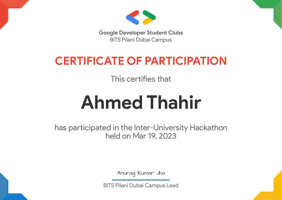


---
Do you confirm to send an email like this to the following

Event
Inter-University Hackathon    1
Name: Name, dtype: int64

---

If yes, type password: ··········


In [181]:
print(msgs[0].get_body())
person = df.iloc[0]
im = draw_certificate(person, y_offset=0)
preview_height = 200
im.resize(
    (
        int(preview_height*(im.width/im.height)),
        preview_height
    )
).show()

print(f"""
---
Do you confirm to send an email like this to the following

{df.groupby("Event")["Name"].count()}

---
""")
sender_password = get_password("If yes, type password: ")

In [182]:
import time

with smtplib.SMTP_SSL("smtp.gmail.com", 465) as server:
    server.login(sender_mail, sender_password)

    sent_count = 0
    for msg in msgs:
        server.send_message(msg)
        sent_count += 1

        if sent_count % 50 == 0:
          time.sleep(100) # 100 sec delay
        else:
          time.sleep(1) # 1 sec delay

# Deleting Output Folder once done

In [183]:
import shutil
shutil.rmtree(output_folder)

In [184]:
print("Everything Done :)")

Everything Done :)
